In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="1"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2024-11-27 17:07:42.332402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 17:07:42.343683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 17:07:42.347285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 17:07:42.907731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


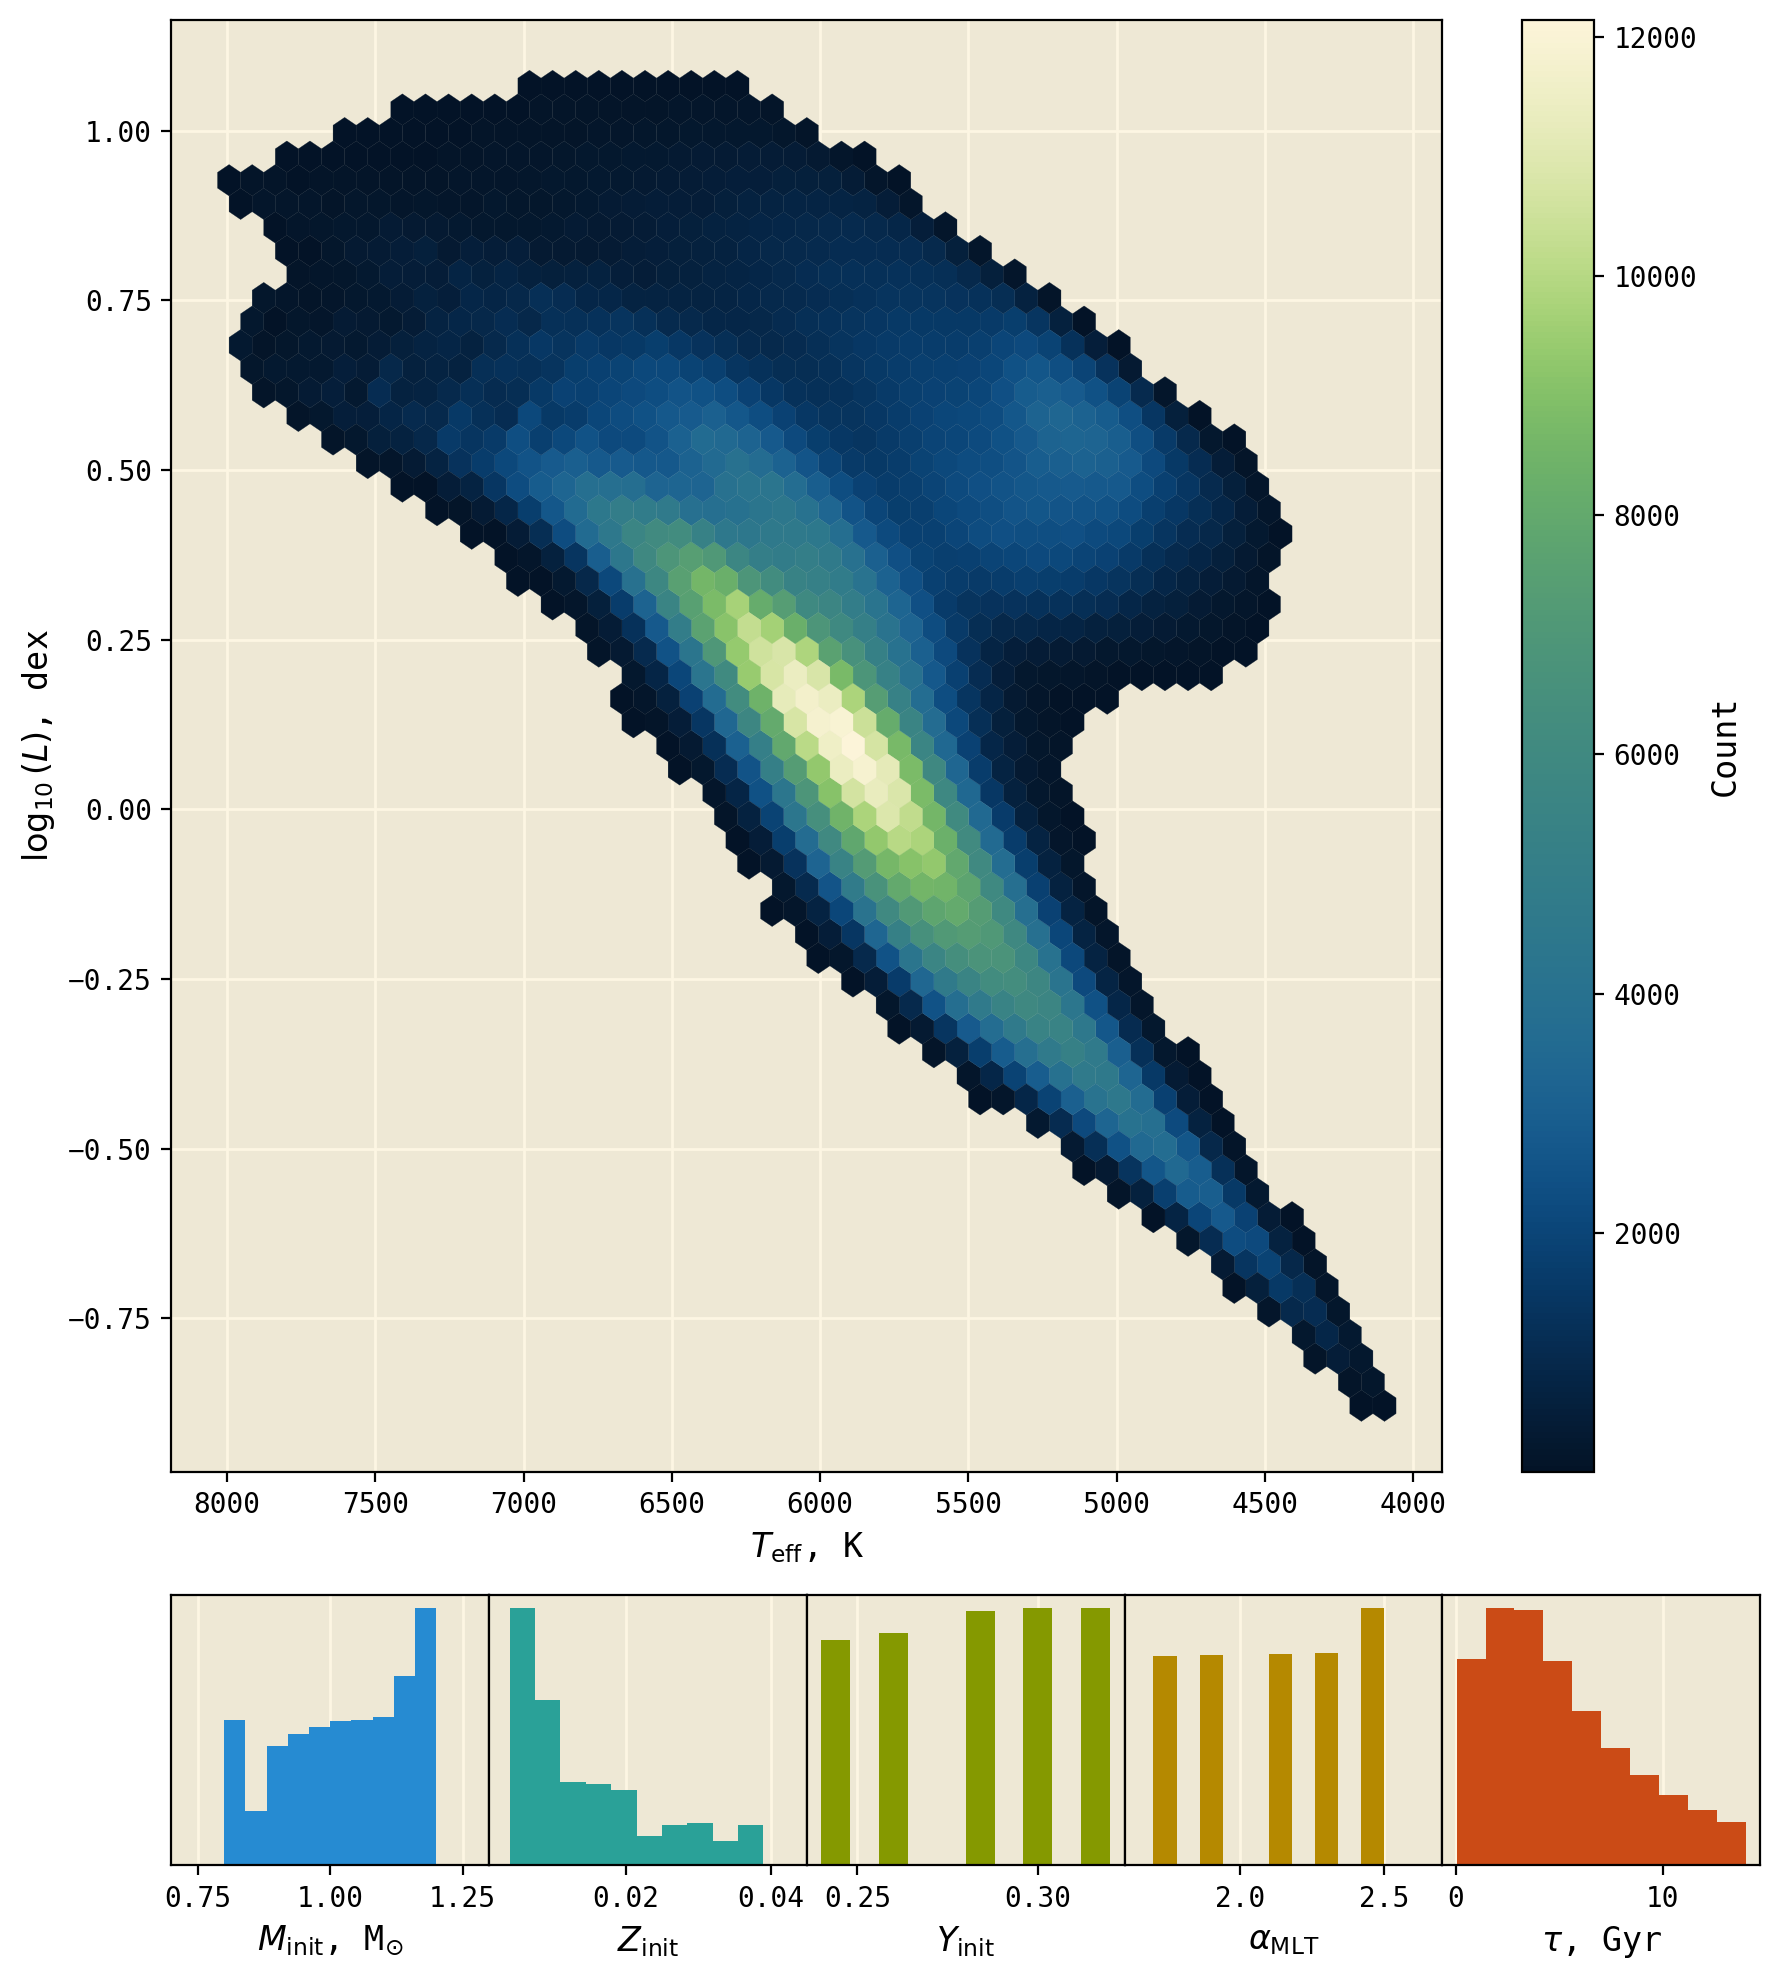

In [105]:
fig = plt.figure(figsize=(9,10), dpi=200)

gs = fig.add_gridspec(5,5)

hex_ax = fig.add_subplot(gs[:4,:])
mass_ax = fig.add_subplot(gs[4,0])
z_ax = fig.add_subplot(gs[4,1])
y_ax = fig.add_subplot(gs[4,2])
mlt_ax = fig.add_subplot(gs[4,3])
age_ax = fig.add_subplot(gs[4,4])

gridsize = 50
hex1 = hex_ax.hexbin(
    df["calc_effective_T"],
    np.log10(df["luminosity"]),
    cmap=cm.navia,
    gridsize=gridsize,
    mincnt=1,
    linewidths=.1,
)

hex1_cbar = fig.colorbar(hex1)
hex1_cbar.set_label('Count')

hex_ax.invert_xaxis()
hex_ax.set_xlabel(r'$T_{\mathrm{eff}}$, K')
hex_ax.set_ylabel(r'$\log_{10}(L)$, dex')

def grid_dist(ax, df, label, c):
    ax.hist(df[label], color=c)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_yticks([])

    if label == "initial_mass":
        ax.set_xlabel(r"$M_\mathrm{init}$, M$_{\odot}$")
        ax.set_xlim(0.7,1.3)

    elif label == "initial_Zinit":
        ax.set_xlabel(r"$Z_\mathrm{init}$")
        ax.set_xlim(0.001,.045)

    elif label == "initial_Yinit":
        ax.set_xlabel(r"$Y_\mathrm{init}$")

    elif label == "initial_MLT":
        ax.set_xlabel(r"$\alpha_{\mathrm{MLT}}$")

        ax.set_xlim(1.6,2.7)


    elif label == "star_age":
        ax.set_xlabel(r"$\tau$, Gyr")


colours = [colour["color"] for colour in plt.rcParams["axes.prop_cycle"]]

grid_dist(mass_ax, df, "initial_mass", colours[0])

grid_dist(z_ax, df, "initial_Zinit", colours[1])

grid_dist(y_ax, df, "initial_Yinit", colours[2])

grid_dist(mlt_ax, df, "initial_MLT", colours[3])

grid_dist(age_ax, df, "star_age", colours[4])

plt.tight_layout()
fig.subplots_adjust(wspace=0)
fig.patch.set_alpha(0.0)
plt.savefig('figs/grid_dists.png', bbox_inches='tight')

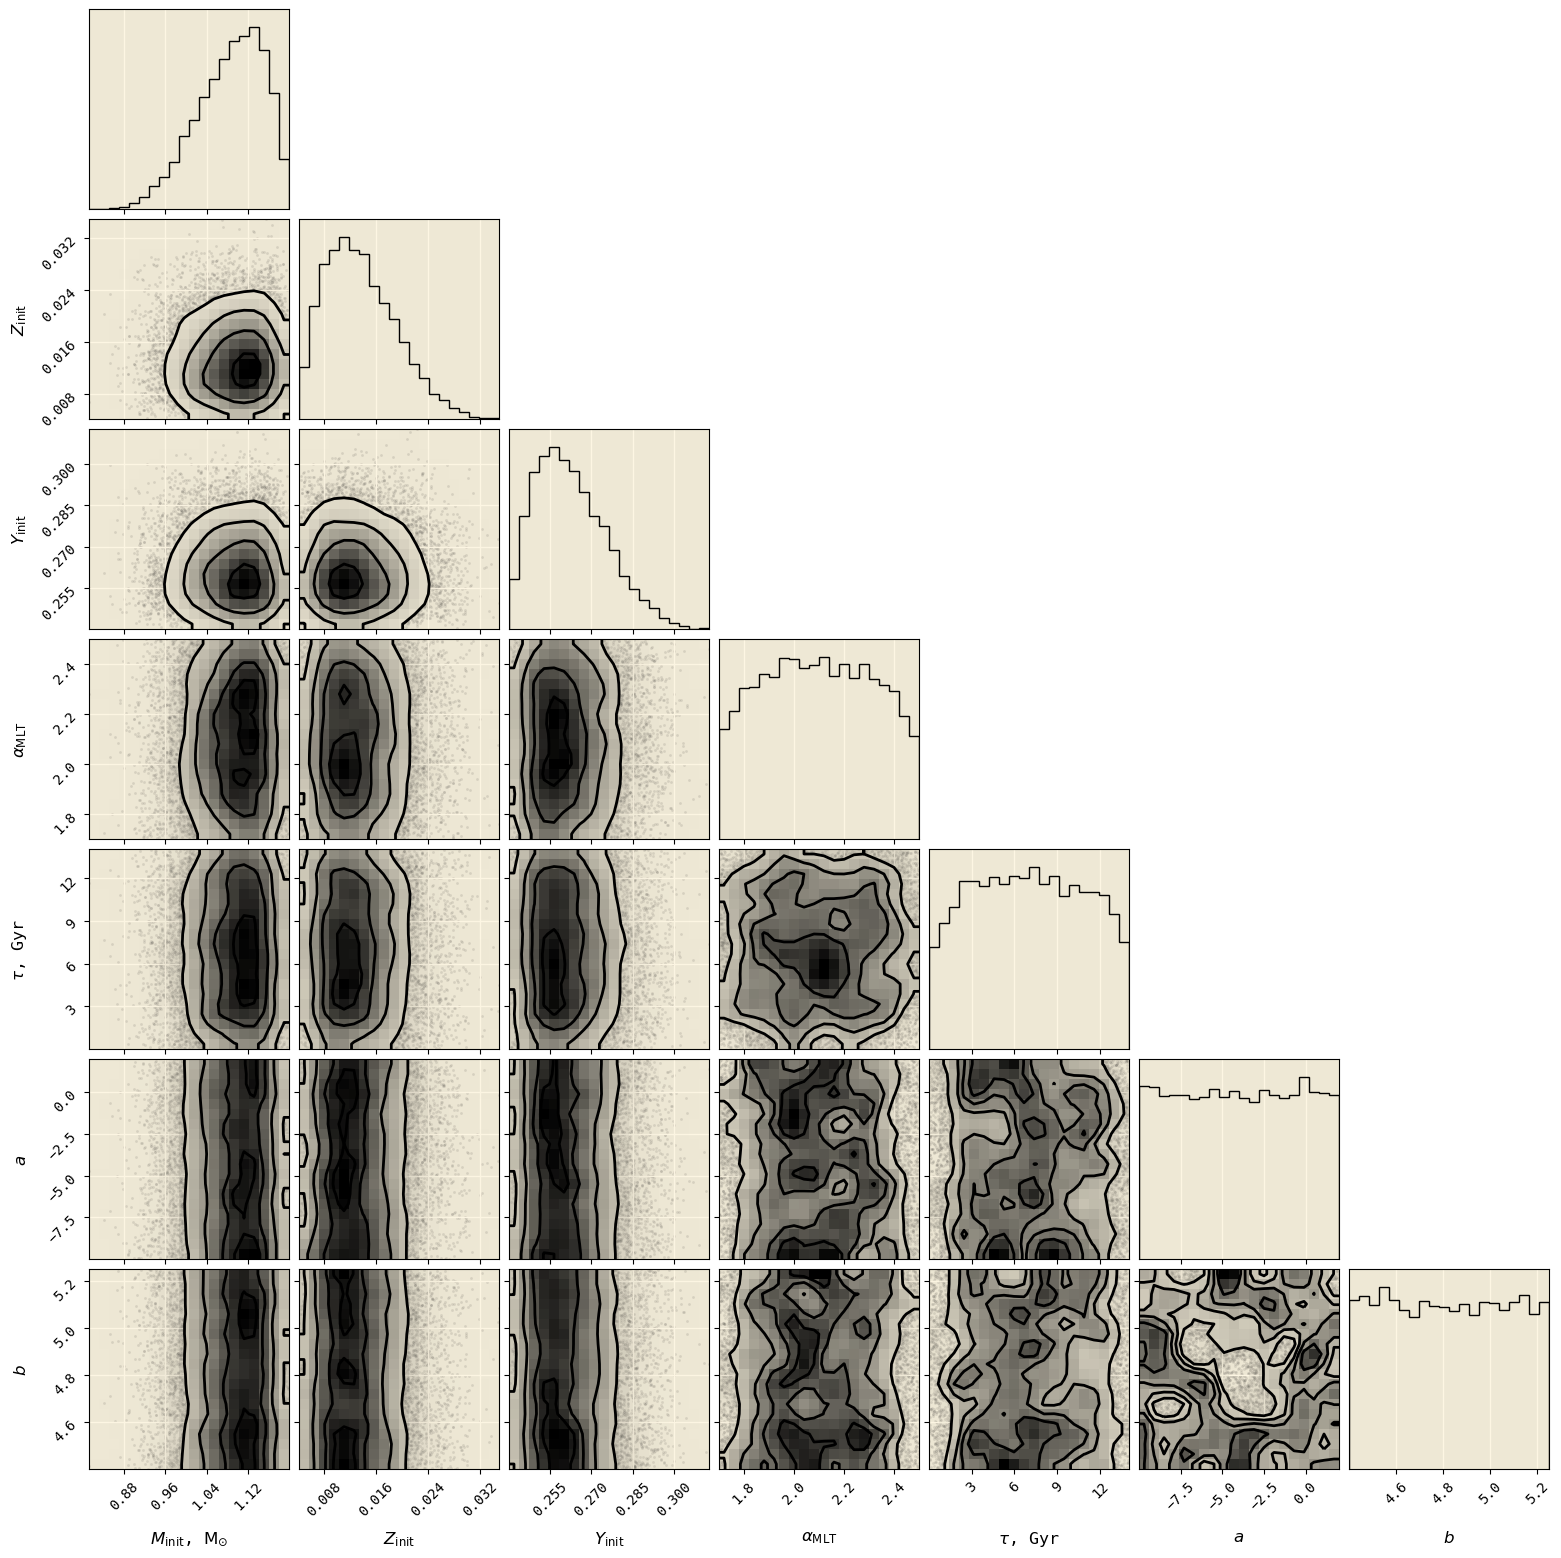

In [123]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

a_prior = prior_funcs.custom_uniform_prior(-10, 2)

b_prior = prior_funcs.custom_uniform_prior(4.4, 5.25)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior, a_prior, b_prior]

titles = [r'$M_{\mathrm{init}}$, $\mathrm{M}_{\odot}$', r'$Z_{\mathrm{init}}$', r'$Y_{\mathrm{init}}$', r'$\alpha_{\mathrm{MLT}}$', r'$\tau$, Gyr', r'$a$', r'$b$']

size = 10000
plot_prior_samples = np.array([prior.rvs(size=size) for prior in priors])
legend_labels = []
corner_color = 'black'

fig = corner.corner(plot_prior_samples.T, labels = titles, color=corner_color, hist_kwargs={'density':True}, smooth=True);
legend_labels = legend_labels + [Line2D([0], [0], marker='o', color =corner_color, markerfacecolor = corner_color, markersize=10, label='priors')]
#plt.suptitle('prior samples')
#plt.legend(handles=legend_labels, bbox_to_anchor=(0., 1.0, 1., .0), loc=0)
#plt.tight_layout()
fig.patch.set_alpha(0.0)
plt.savefig('figs/prior.png', bbox_inches='tight')

In [4]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" + pitchfork_name + ".pkl", "rb") as fp:
    pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info["parameter_ranges"]

outputs = ["calc_effective_T", "luminosity", "star_feh"] + [
    f"nu_0_{i}" for i in range(6, 41)
]

df[["pred_" + output for output in outputs]] = pitchfork.predict(df[inputs].values)

df[["resid_" + output for output in outputs]] = (
    df[outputs].values - df[["pred_" + output for output in outputs]].values
)

df[["perc_" + output for output in outputs]] = ((df[["resid_" + output for output in outputs]].abs() / df[[output for output in outputs]].values )*100)

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


/tmp/ipykernel_281532/822210133.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["perc_" + output for output in outputs]] = ((df[["resid_" + output for output in outputs]].abs() / df[[output for output in outputs]].values )*100)
/tmp/ipykernel_281532/822210133.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[["perc_" + output for output in outputs]] = ((df[["resid_" + output for output in outputs]].abs() / df[[output for output in outputs]].values )*100)
/tmp/ipykernel_281532/822210133.py:19: PerformanceWarning: D

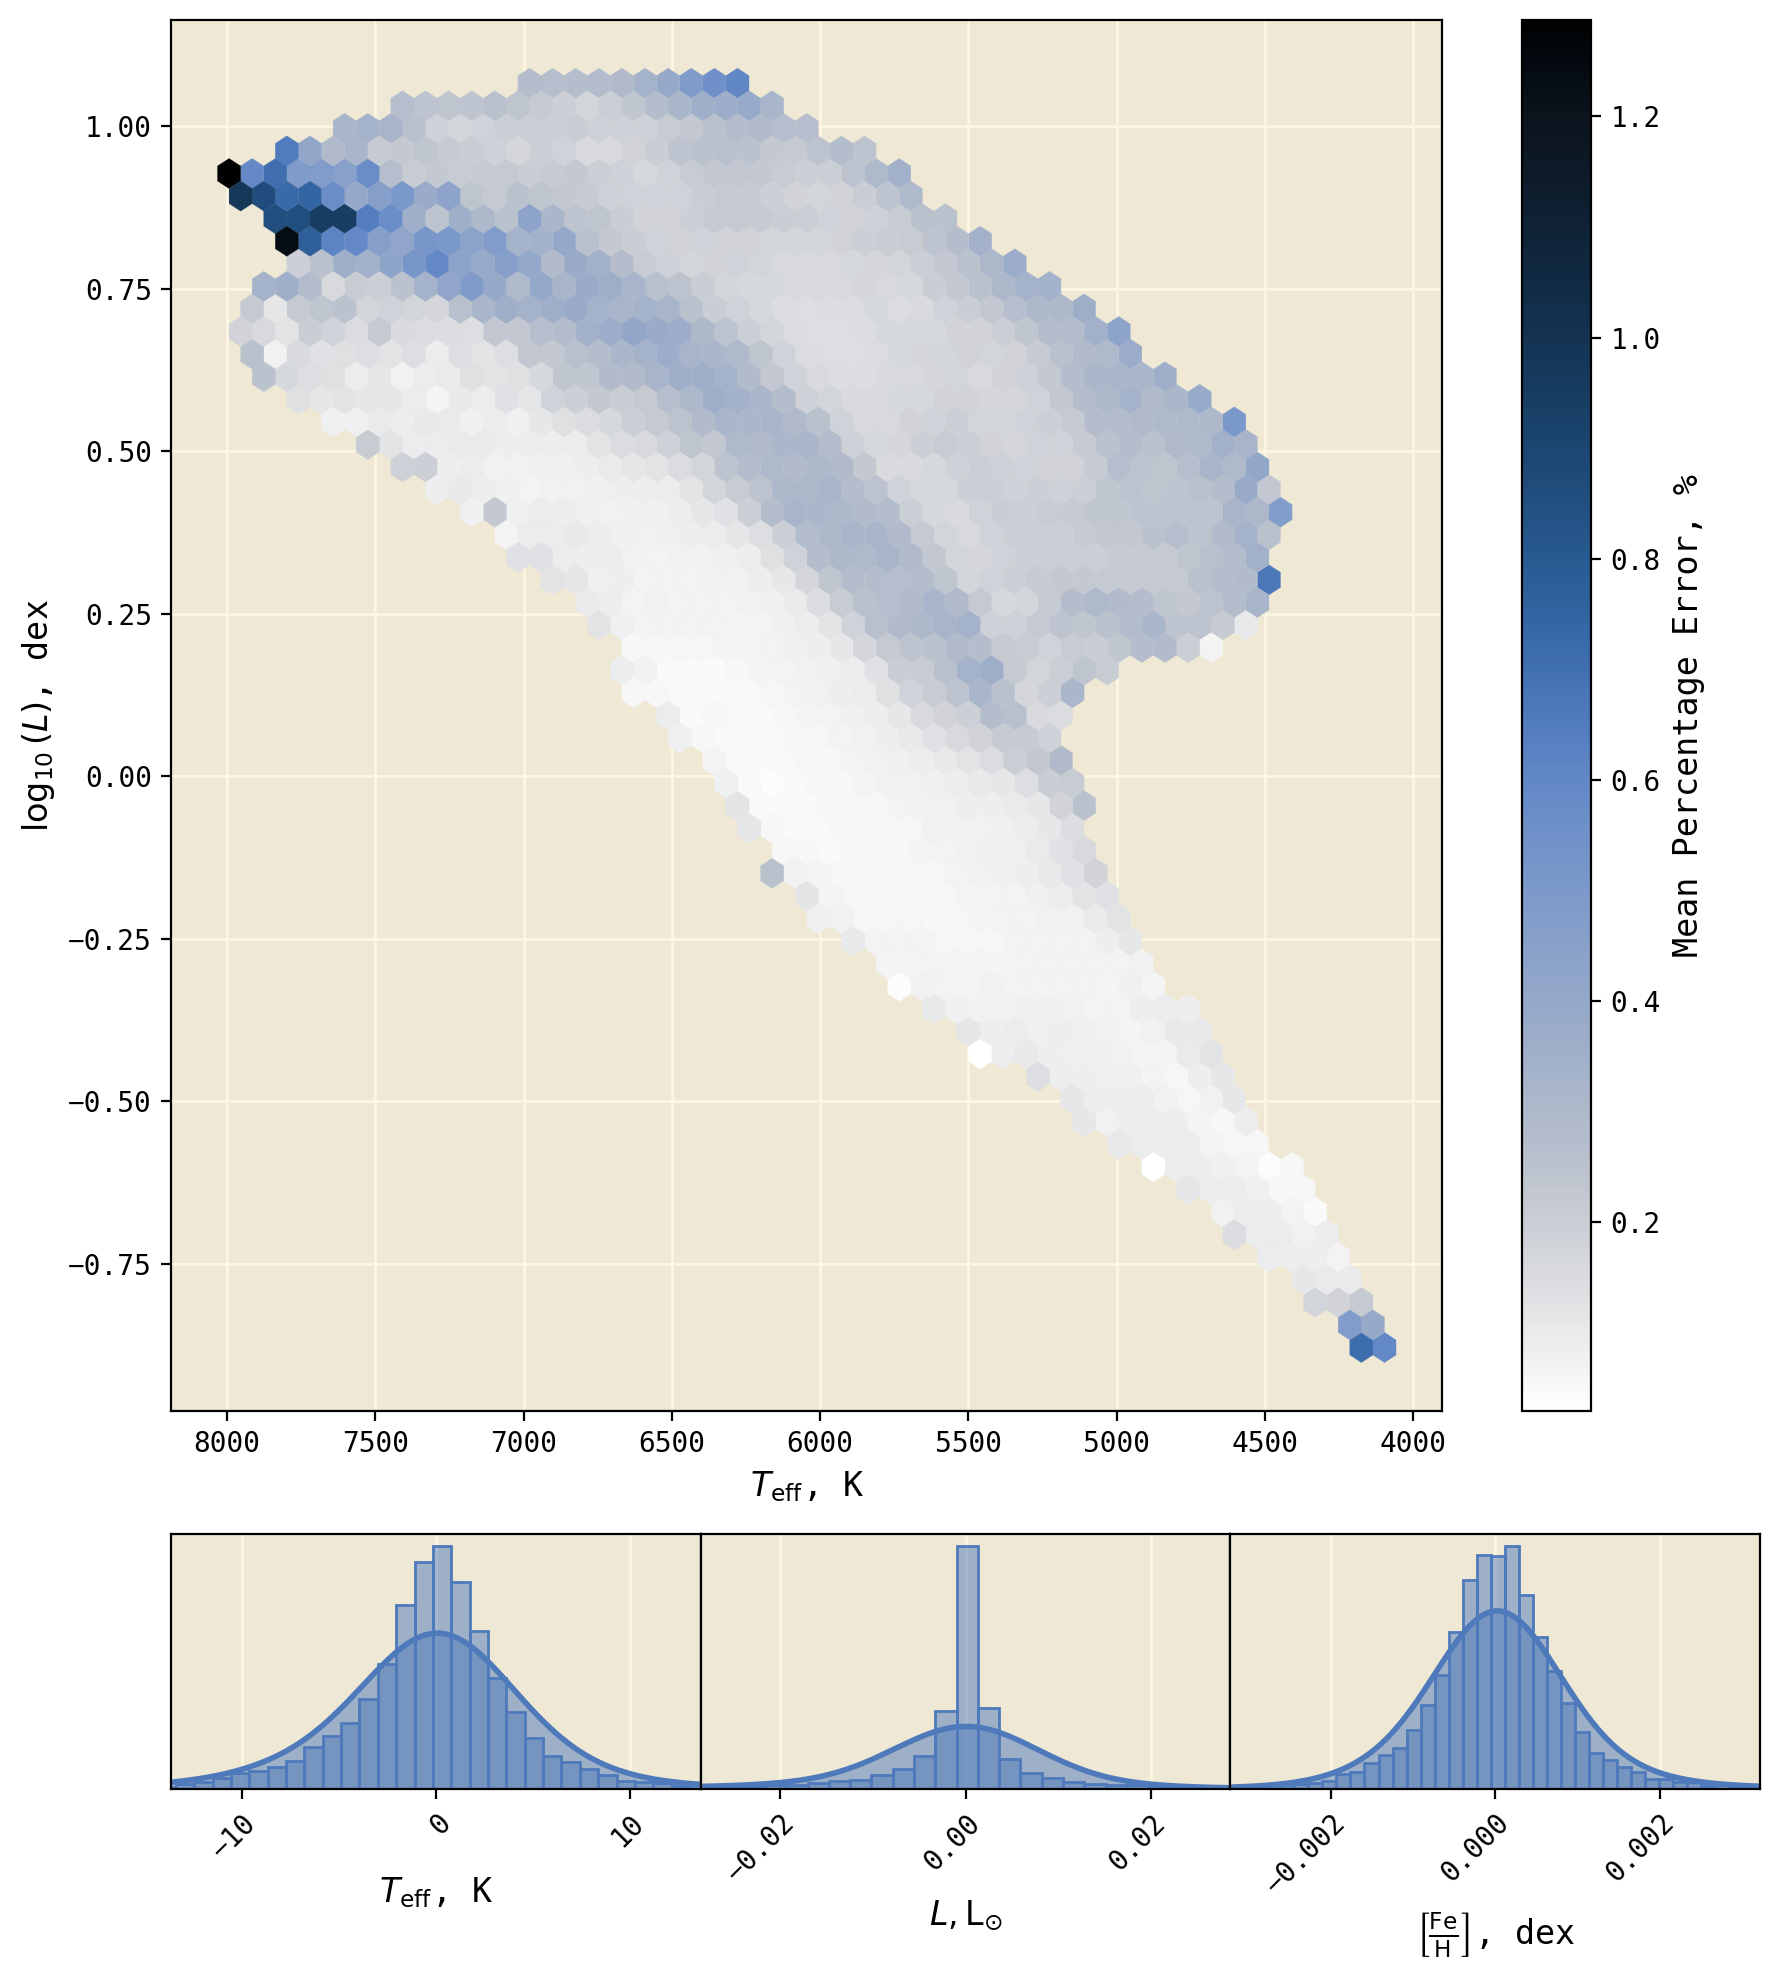

In [104]:
fig = plt.figure(figsize=(9,10), dpi=200)

gs = fig.add_gridspec(5,3)

hex_ax = fig.add_subplot(gs[:4,:])

t_ax = fig.add_subplot(gs[4:,0])
l_ax = fig.add_subplot(gs[4:,1])
feh_ax = fig.add_subplot(gs[4:,2])

gridsize = 50
hex1 = hex_ax.hexbin(
    df["calc_effective_T"],
    np.log10(df["luminosity"]),
    C=df[["perc_"+output for output in ["calc_effective_T","luminosity"]]].mean(axis=1),
    cmap=cm.oslo_r,
    gridsize=gridsize,
    mincnt=1,
    linewidths=0.1,
    reduce_C_function=np.mean
)

hex1_cbar = fig.colorbar(hex1)
hex1_cbar.set_label('Mean Percentage Error, %')

hex_ax.invert_xaxis()
hex_ax.set_xlabel(r'$T_{\mathrm{eff}}$, K')
hex_ax.set_ylabel(r'$\log_{10}(L)$, dex')

####################################################
def residual_dist(df, label, ax, cmap = cm.oslo_r, samples=10000):
    residuals = df["resid_"+label].sample(n=samples, random_state=42).values


    colour = cmap(0.5)
    
    ax.hist(residuals, orientation='vertical', density=True, bins='scott', alpha=0.5, color=colour)
    ax.hist(residuals, orientation='vertical', density=True, facecolor="none", bins='scott', alpha=1, linewidth=1, edgecolor=colour)
    
    kde= scipy.stats.gaussian_kde(residuals, bw_method=0.5)
    residual_min = residuals.min()
    kde_x = np.linspace(-5*residual_min, 5*residual_min, samples)
    kde_y = kde(kde_x)
    ax.plot(kde_x, kde_y, c=colour)
    ax.fill_between(kde_x, 0, kde_y, color=colour,alpha=0.5)

    
    xlim = 0.1 * abs(max((residuals.min(), residuals.max()), key=abs))
    ax.set_yticks([])
    ax.set_xlim(xmin=-xlim, xmax=xlim)
    ax.set_xticks(ax.get_xticks()[1:-1]) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    if label == "calc_effective_T":
        ax.set_xlabel(r'$T_{\mathrm{eff}}$, K')

    elif label == "luminosity":
        ax.set_xlabel(r'$L, \mathrm{L}_{\odot}$')

    elif label == "star_feh":
        ax.set_xlabel(r"$\left[\frac{\mathrm{Fe}}{\mathrm{H}}\right]$, dex")


residual_dist(df, "calc_effective_T", t_ax)

residual_dist(df, "luminosity", l_ax)

residual_dist(df, "star_feh", feh_ax)

plt.tight_layout()
fig.subplots_adjust(wspace=0)
fig.patch.set_alpha(0.0)
plt.savefig('figs/classical_unc.png', bbox_inches='tight')

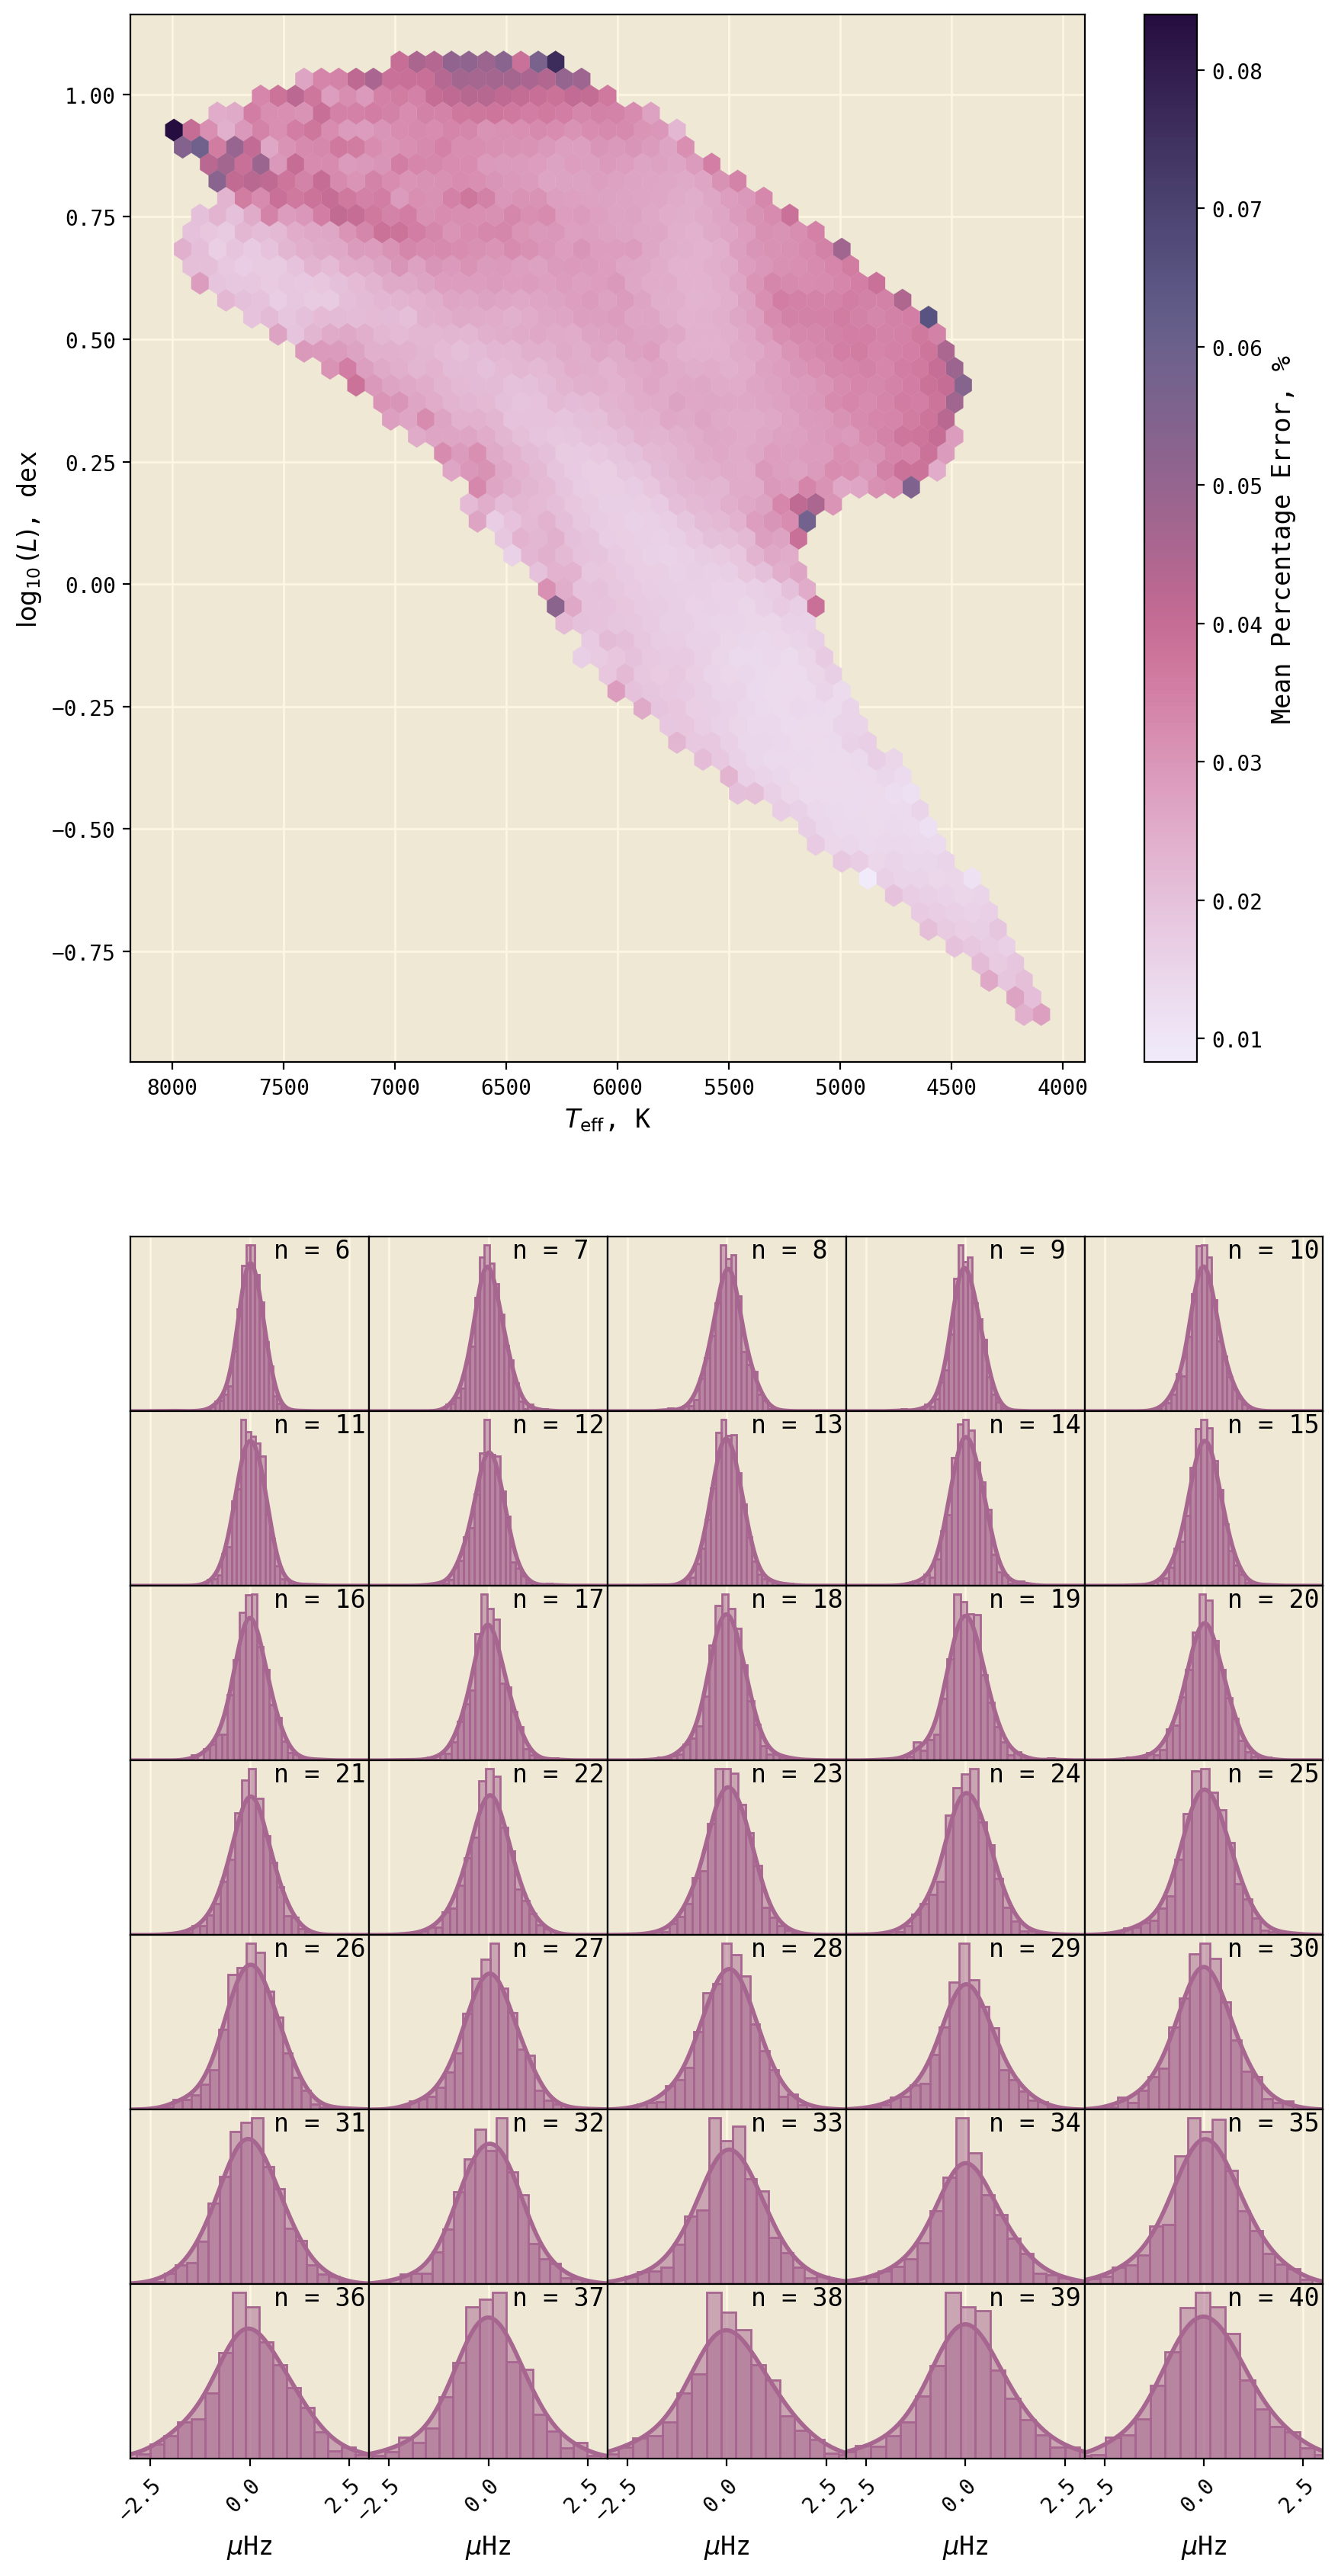

In [121]:
fig = plt.figure(figsize=(9,17), dpi=200)

colourmap = cm.acton_r
gs = fig.add_gridspec(14,5)

hex_ax = fig.add_subplot(gs[:6,:])

gridsize = 50
hex1 = hex_ax.hexbin(
    df["calc_effective_T"],
    np.log10(df["luminosity"]),
    C=df[["perc_"+output for output in [f"nu_0_{i}" for i in range(6, 41)]]].mean(axis=1),
    cmap=colourmap,
    gridsize=gridsize,
    mincnt=1,
    linewidths=0.1,
    reduce_C_function=np.mean
)

hex1_cbar = fig.colorbar(hex1)
hex1_cbar.set_label('Mean Percentage Error, %')

hex_ax.invert_xaxis()
hex_ax.set_xlabel(r'$T_{\mathrm{eff}}$, K')
hex_ax.set_ylabel(r'$\log_{10}(L)$, dex')
####################################################

fig.add_subplot(gs[6,:]).set_visible(False)

####################################################
def residual_dist(df, n, ax, cmap = colourmap, x_tick_flag = False, samples=1000):
    label = f"nu_0_{n}"
    residuals = df["resid_"+label].sample(n=samples, random_state=42).values


    colour = cmap(0.5)
    
    ax.hist(residuals, orientation='vertical', density=True, bins='scott', alpha=0.5, color=colour)
    ax.hist(residuals, orientation='vertical', density=True, facecolor="none", bins='scott', alpha=1, linewidth=1, edgecolor=colour)
    
    kde= scipy.stats.gaussian_kde(residuals, bw_method=0.5)
    residual_min = residuals.min()
    kde_x = np.linspace(-5*residual_min, 5*residual_min, samples)
    kde_y = kde(kde_x)
    ax.plot(kde_x, kde_y, c=colour)
    ax.fill_between(kde_x, 0, kde_y, color=colour,alpha=0.5)

    ax.text(0.6,0.88,f"n = {n}", size=12, transform=ax.transAxes)
    
    ax.set_yticks([])
    ax.set_xlim(xmin=-3, xmax=3)

    if x_tick_flag:
        ax.set_xticks(ax.get_xticks()[1:-1]) 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
        ax.set_xlabel(r"$\mu$Hz")

    else:
        ax.set_xticks(ax.get_xticks()[1:-1], labels=[])

for n in range(6,41):
    print(f"current n = {n}", end="\r")
    n_ax_idx = n-6

    gs_x = 7+(n_ax_idx//5)
    gs_y = n_ax_idx%5
    n_ax = fig.add_subplot(gs[gs_x,gs_y])

    if gs_x ==13:
        residual_dist(df, n, n_ax, x_tick_flag = True)
    else:
        residual_dist(df, n, n_ax, x_tick_flag = False)

plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
fig.patch.set_alpha(0.0)
plt.savefig('figs/astero_unc.png', bbox_inches='tight')